## Loan Classification

### Build Classification Models

### Summary

This is Part 2 of the project Loan Classification: Build Classification Models. 
    
In this project I analyze the <a href="https://www.kaggle.com/datasets/itssuru/loan-data">Loan Data</a> provided 
by <a href="https://www.lendingclub.com/investing/peer-to-peer">Lending Club</a>.

The analysis covers **data exploration, visualization**, **data processing** and **building a classifier** to predict whether 
or not the **borrower paid back their loan in full**.

The project is done in Python. It uses Pandas and Numpy libraries for data manipulation, Seaborn and Matplotlib for 
visualizations and Sklean for building the classifier.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *

### Load data

In [2]:
# Retrieve data in a pandas dataframe
loan = pd.read_csv('loan_data.csv')

# Print the shape and the first rows
print(loan.shape)
print()
loan.head()

(9578, 14)



,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## Data Preprocessing

For data preprocessing I followed the steps below.

### Apply logarithm transformation to revolving balance

In [3]:
# Apply logarithm transformation to 'revol.bal'
loan['log_revol.bal'] = loan['revol.bal'].\
              apply(lambda x: 0 if x <= 0 else np.log(x))

### Binning categories

In [4]:
# Binning 'inq.last.6mths'

# Create custom bins
custom_bins_inq = [-1, 0, 2, 5, float('inf')]
# Label the bins
bin_labels_inq = ['bin1', 'bin2', 'bin3', 'bin4']
# Bin categories in 'inq.last.6mths'
loan['inq.last.6mths_bin'] = pd.cut(loan['inq.last.6mths'], 
                             bins=custom_bins_inq, 
                             labels=bin_labels_inq)

# Binning 'delinq.2yrs'

# Create custom bins
custom_bins_delinq = [-1, 0, 1, float('inf')]
# Label the bins
bin_labels_delinq = ['bin1', 'bin2', 'bin3']
# Bin categories in 'delinq.2yrs'
loan['delinq.2yrs_bin'] = pd.cut(loan['delinq.2yrs'], 
                          bins=custom_bins_delinq, 
                          labels=bin_labels_delinq)

# Bin 'pub.rec'

# Create custom bins
custom_bins_pub = [-1, 0, float('inf')]
# Label the bins
bin_labels_pub = ['bin1', 'bin2']
# Bin categories in 'pub.rec'
loan['pub.rec_bin'] = pd.cut(loan['pub.rec'], 
                      bins=custom_bins_pub, 
                      labels=bin_labels_pub)

### Category encoding

In [5]:
# List of categorical columns to label encode
cols_to_encode = ['inq.last.6mths_bin', 
                  'delinq.2yrs_bin', 
                  'pub.rec_bin']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each specified column
for col in cols_to_encode:
    loan[col] = label_encoder.fit_transform(loan[col])
    
# Encode categories in 'purpose'
loan = pd.get_dummies(loan,
        columns = ['purpose'])

### Drop redundant columns

In [6]:
# Drop the columns 'revol.bal', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec' from the DataFrame
loan = loan.drop(columns=[
    'revol.bal', 'inq.last.6mths', 
    'delinq.2yrs', 'pub.rec'])

# Verify the columns have been dropped
print(loan.shape)
loan.head(3)

(9578, 20)


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.util,not.fully.paid,log_revol.bal,inq.last.6mths_bin,delinq.2yrs_bin,pub.rec_bin,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,52.1,0,10.270004,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,76.7,0,10.422966,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,25.6,0,8.163656,1,0,0,0,0,1,0,0,0,0


### Normalize features

In [7]:
# Make a copy of the dataframe
features = loan.copy()

# Select columns to be normalized
cols_normalize=[
    'credit.policy', 'int.rate', 'installment', 
    'log.annual.inc', 'dti',  'fico', 
    'days.with.cr.line', 'revol.util', 
    'log_revol.bal']

# Create a Numpy array with the values of the columns
x = features[cols_normalize].values

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data
x_scaled = scaler.fit_transform(x)

# Create a dataframe for normalized features
features_temp = pd.DataFrame(x_scaled, 
                columns=cols_normalize, 
                index=features.index)

# Replace features dataframe with normalized values
features[cols_normalize] = features_temp

## Build a Classification Model

We will build a Classifier to **predict** whether a **loan will be paid back**. 

In training and evaluation of the model we'll **account** for:
- **class imbalance** 
- the **importance** of accurately **predicting** whether a loan will **not be paid back** rather than if a loan is paid

### Split the dataset into training and testing sets 

In [8]:
# Create the label
y = features['not.fully.paid']

# Drop the column "not.fully.paid"
features = features.drop('not.fully.paid', axis=1)

# Make a list with all the columns in dataframe
cols = list(features.columns)

# Create the features dataframe
X = features[cols]

# Split the dataset into training 
# set (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        test_size=0.3, random_state=123)

# Print the shape of the training and testing datasets
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (6704, 19)
y_train:  (6704,)
X_test:  (2874, 19)
y_test:  (2874,)


### Initialize and train the models

We'll train the following models:
- **Logistic Regression**
- **Random Forest**
- **Gradient Boosting**

In [9]:
# Create a dictionary with the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000, random_state = 0),
    'Random Forest': RandomForestClassifier(random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, 
                         loss='deviance', learning_rate=0.05, 
                         max_depth=5, min_samples_leaf=5)
}

# Fit the models to train data
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Print the evaluation metrics
    print(f"Model: {name}")
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("******************************************")

Model: Logistic Regression

Accuracy: 0.8347
Precision: 0.6471
Recall: 0.0229
F1 Score: 0.0443
ROC AUC Score: 0.6820
******************************************
Model: Random Forest

Accuracy: 0.8337
Precision: 0.6000
Recall: 0.0125
F1 Score: 0.0245
ROC AUC Score: 0.6531
******************************************
Model: Gradient Boosting

Accuracy: 0.8326
Precision: 0.4878
Recall: 0.0417
F1 Score: 0.0768
ROC AUC Score: 0.6681
******************************************


**Logistic Regression** model has an **Accuracy of 0.83**, while **Random Forest** and **Gradient Boosting** have 
slightly **lower accuracy** values. 

The metrics include also Recall and Precision for all the models:
- What proportion of actual loan defaults was identified correctly? This is the "Recall".
- What proportion of positive loan defaults identifications was correct? This is the "Precision"

For **Logistic Regression**, Precision is 0.64, Recall is low with a value of **0.02**, and F1 score is 
0.04. 

A **Recall** value of **0.02** means that the **model identifies only 2% of all unpaid loans**.

### Confusion matrix for Logistic Regression


TP, TN, FP, FN: 11 , 2388 , 6 , 469


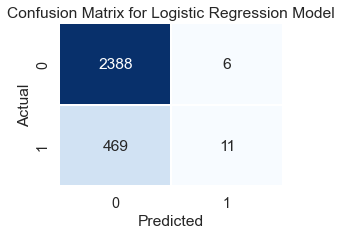

In [10]:
# Get predicted values for initial Logistic Regression
log = LogisticRegression(max_iter=5000, random_state = 0)   
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

# Generate a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print ("\nTP, TN, FP, FN:", 
       tp, ",", tn, ",", fp, ",", fn)

# Build the Confusion Matrix plot for Logistic Regression model
plt.figure(figsize=(4,3))
sns.set(font_scale=1.3)            
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            linewidths=0.2, cbar=False) 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

Confusion matrix for the initial **Logistic Regression** shows that there are **469 false negatives** and **6 false positives**.

**False negatives** are loans that are **actually not paid** but are **classified as paid**, thus 
for the **lender**,  the **false negatives are more costly** than false positives. 

Our **focus** is **minimizing the false negatives** which would **maximize the Recall**.

Since this is an **imbalanced dataset**, we will consider **Precision and Recall** as **measures for model performance**, **instead** of **Accuracy**. 

### Balance the class distribution  by applying SMOTE technique

We'll apply next the SMOTE algorithm (Synthetic Minority Oversampling Technique) by oversampling the minority class on train
data. By using SMOTE, it can be increased Recall at the cost of Precision.

In [11]:
# Summarize the class distribution in y_train using a Counter object
print('Original dataset shape {}'.format(Counter(y_train)))

# Apply SMOTE function to oversample 
# minority class on train data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Summarize the class distribution in resampled train data
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({0: 5651, 1: 1053})
Resampled dataset shape Counter({0: 5651, 1: 5651})


### Train the models on resampled data

In [12]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000, random_state = 0),
    'Random Forest': RandomForestClassifier(random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, 
                         loss='deviance', learning_rate=0.05, 
                         max_depth=5, min_samples_leaf=5)
}


# Fit the models to resampled train data
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Print the evaluation metrics
    print(f"Model after resampling: {name}")
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("******************************************")

Model after resampling: Logistic Regression

Accuracy: 0.6472
Precision: 0.2586
Recall: 0.5958
F1 Score: 0.3607
ROC AUC Score: 0.6735
******************************************
Model after resampling: Random Forest

Accuracy: 0.7738
Precision: 0.2652
Recall: 0.2000
F1 Score: 0.2280
ROC AUC Score: 0.6304
******************************************
Model after resampling: Gradient Boosting

Accuracy: 0.7439
Precision: 0.2793
Recall: 0.3375
F1 Score: 0.3057
ROC AUC Score: 0.6325
******************************************


We observe that by **reweighting** the **proportion** of the **classes**, the **Recall increased at the cost of Precision** for **all models**.

For **Logistic Regression**, **Recall** increased to **0.6**, which means that the **model identifies 60% of all unpaid loans**.

Meantime **Precision** dropped to **0.26**, while F1 score increased to 0.36.

### Confusion matrix for Logistic Regression after applying SMOTE


TP, TN, FP, FN: 286 , 1574 , 820 , 194


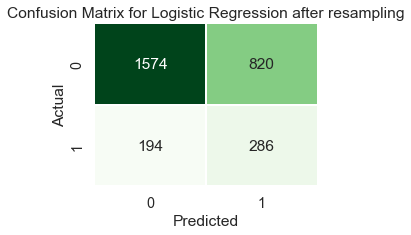

In [13]:
# Get predicted values for Logistic Regression with resampled data
log = LogisticRegression(max_iter=5000, random_state = 0)   
log.fit(X_train_res, y_train_res)
y_pred = log.predict(X_test)

# Generate a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print ("\nTP, TN, FP, FN:", 
       tp, ",", tn, ",", fp, ",", fn)

# Build the Confusion Matrix plot for Logistic Regression model
plt.figure(figsize=(4,3))
sns.set(font_scale=1.3)            
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", 
            linewidths=0.2, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression after resampling')
plt.show()

The **false negatives decreased** from **469 to 194** and the **false positives increased** from **6 to 820**.

The result shows that **Logistic Regression** model **after resampling** is **better** at **predicting** if a **loan 
will not be paid back**.

### Precision-Recall curve for Logistic Regression classifier

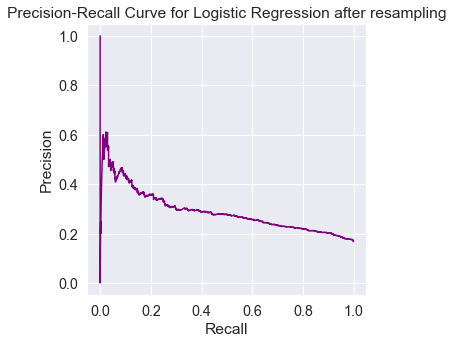

In [14]:
# Get probabilities for class 1
y_score = log.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# Create precision-recall curve
plt.figure(figsize=(5,5))
plt.plot(recall, precision, color='purple')  
plt.title('Precision-Recall Curve for Logistic Regression after resampling')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

At a **high threshold** value, **Recall** is **0.03** and **Precision** is **0.6**, while at **low threshold** values, **Recall increases** to a value of **1**, while **Precision decreases** below **0.2**.

The **precision-recall curve** allows us to **visualize** these **metrics** at **various threshold levels** to observe the **tradeoff** between the 
two.

### Conclusions

In this project three classifier models were built to predict whether or not the borrower paid back their loan in full.
The models trained and evaluated were Logistic Regression, Random Forest and Gradient Boosting. The results showed a low Recall
value, which means that the model misses an important number of positive cases. Being an imbalanced dataset, Recall takes 
precedence because the minority class (the positive class) is the primary focus, especially on applications like loan lending. 

Next, the SMOTE technique was applied by oversampling the minority class on train data, then the models were re-trained and 
re-evaluated on resampled data. The results showed a higher value for Recall and lower for Precision. By plotting the 
Precision-Recall curve, it could be observed the tradeoff between the two.

Achieving a better balance between recall and precision can help mitigate the risks of defaulters slipping through undetected, 
potentially resulting in financial losses for the lender. However, the specific trade-off between recall and precision should 
align with the goals and consequences of the particular application.